# Mapping the places affected by the city's proposal

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

Read raw data from various sources

In [2]:
rawfiles = {
    'homeless': 'la_homeless_facilities.geojson',
    'childcare': 'la_city_childcare.geojson',
    'parks': 'la_city_county_parks.geojson',
    'public_schools': 'lausd_schools_boundaries_clipped.geojson',
    'private_schools': 'la_county_private_school_parcels.geojson',
    'special_venues': 'la_city_special_venues.geojson'
}

In [3]:
def readprocess(fpath, category):
    gdf = gpd.read_file(f'input/polygons/{fpath}')[['geometry']]
    gdf['category'] = category
    # use a projection in meters for accurate area calculations
    gdf.to_crs({'init': 'epsg:3310'}, inplace=True)
    return gdf

In [4]:
processedshapes = {r: readprocess(rawfiles[r], r) for r in rawfiles}

In [5]:
alldata = pd.concat(processedshapes.values(), sort=False)

In [6]:
alldata.crs

{'init': 'epsg:3310'}

Conversion factor

In [7]:
SQMETERS_TO_SQMI = 2590000

In [8]:
alldata['area'] = alldata.geometry.area / SQMETERS_TO_SQMI

In [9]:
alldata.head()

,geometry,category,area
0,POLYGON ((162235.1707873342 -439706.7449111249...,homeless,0.000647
1,POLYGON ((157825.9805167973 -445239.4206681503...,homeless,0.000216
2,"POLYGON ((159349.7365253346 -449897.639234968,...",homeless,0.000179
3,"POLYGON ((159349.7365253346 -449897.639234968,...",homeless,0.000179
4,POLYGON ((159601.9190465482 -437824.3984980457...,homeless,0.000238


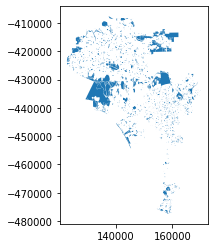

In [10]:
alldata.plot()

**How many of each shape did we bring in and how much area (in square miles) does that category add up to?**

In [11]:
alldata.groupby('category')['area'].aggregate(['count','sum'])

,count,sum
category,,
childcare,1161,7.349280
homeless,36,0.091682
parks,836,70.899342
private_schools,842,1.940742
public_schools,640,8.146147
special_venues,9,0.691073


Combine the polygons into one shape to account for overlaps

In [12]:
def adddummyfield(row):
    row['category'] = 'x'
    return row

In [13]:
dissolvedshapes = alldata.apply(adddummyfield, axis=1).dissolve('category')

In [14]:
dissolvedshapes.crs = {'init':'epsg:3310'}

In [15]:
dissolvedshapes.head()

,geometry,area
category,,
x,(POLYGON Z ((162629.5480530739 -451456.3778770...,0.000647


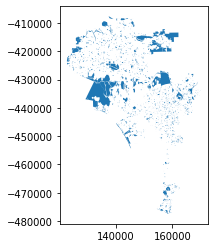

In [16]:
dissolvedshapes.plot()

Draw the 500-foot buffer around each of these properties (152.4 meters)

In [17]:
alldata['withbuffer'] = alldata.buffer(152.4)

In [18]:
alldata.head()

,geometry,category,area,withbuffer
0,POLYGON ((162235.1707873342 -439706.7449111249...,homeless,0.000647,POLYGON ((162338.1895894707 -439821.7115103276...
1,POLYGON ((157825.9805167973 -445239.4206681503...,homeless,0.000216,POLYGON ((157978.3442876927 -445236.0978201961...
2,"POLYGON ((159349.7365253346 -449897.639234968,...",homeless,0.000179,POLYGON ((159353.2306388219 -450049.9991744893...
3,"POLYGON ((159349.7365253346 -449897.639234968,...",homeless,0.000179,POLYGON ((159353.2306388219 -450049.9991744893...
4,POLYGON ((159601.9190465482 -437824.3984980457...,homeless,0.000238,POLYGON ((159671.0848443312 -437688.5977159528...


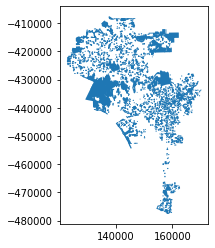

In [19]:
gpd.GeoSeries(alldata['withbuffer']).plot()

Combine into one layer

In [20]:
allbuffers = gpd.GeoDataFrame(
    alldata[['category','withbuffer']].rename(columns={'withbuffer':'geometry'})
)\
.apply(adddummyfield,axis=1)\
.dissolve(by='category')

In [21]:
allbuffers.crs = {'init':'epsg:3310'}

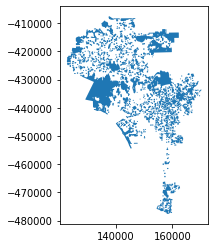

In [22]:
allbuffers.plot()

Subtract the shape of the dissolved polygons

In [23]:
allbuffers['difference'] = allbuffers.apply(lambda x: x['geometry'].difference(dissolvedshapes.geometry[0]), axis=1)

Clip to shape of L.A., to account for buffers that go outside city boundaries

In [24]:
cityofla = gpd.read_file('input/neighborhoods/la-city-boundary.geojson').to_crs({'init': 'epsg:3310'})

In [25]:
allbuffers['clipped'] = allbuffers.apply(lambda x: x['difference'].intersection(cityofla.geometry[0]), axis=1)

Track how the area changes as we applied each transformation

In [26]:
allbuffers.apply(lambda x: gpd.GeoSeries(x).area / SQMETERS_TO_SQMI)

,geometry,difference,clipped
category,,,
x,220.439807,136.171638,127.324442


In [27]:
finalbuffers = gpd.GeoDataFrame(allbuffers[['clipped']].reset_index(drop=True).rename(columns={'clipped':'geometry'}))

In [28]:
finalbuffers.head()

,geometry
0,(POLYGON Z ((158699.2582505594 -475485.0419580...


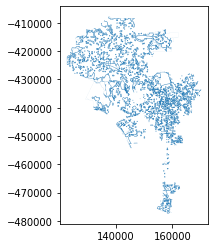

In [29]:
finalbuffers.plot()

Read LA Times neighborhood file (with Skid Row delineated in downtown)

In [30]:
hoods = gpd.read_file('input/neighborhoods/custom-la-hoods-skid-row.geojson')

In [31]:
hoods.crs

{'init': 'epsg:4326'}

In [32]:
hoods.to_crs({'init': 'epsg:3310'}, inplace=True)

In [33]:
hoods.head()

,name,geometry
0,Adams-Normandie,(POLYGON ((156139.6401248094 -440624.691527145...
1,Arleta,(POLYGON ((145361.3096072993 -420096.183241404...
2,Arlington Heights,(POLYGON ((155472.5469032948 -438950.195603739...
3,Atwater Village,(POLYGON ((158739.6492951898 -427752.278756475...
4,Baldwin Hills/Crenshaw,(POLYGON ((151801.1076706515 -442096.112350080...


In [34]:
len(hoods)

115

**How much area is in the city of L.A.?**

In [35]:
totalcityarea = hoods.geometry.area.sum() / SQMETERS_TO_SQMI
totalcityarea

475.6773404706595

**How much total area is in these combined buffers?**

In [36]:
totalbufferarea = allbuffers.clipped[0].area / SQMETERS_TO_SQMI
totalbufferarea

127.3244417323887

**What percentage of the city is inacessible for sleeping under this proposal?**

In [37]:
totalbufferarea / totalcityarea

0.2676697645643734

Calculate the intersection of each hood with the buffers

In [38]:
b = finalbuffers.geometry[0]

In [39]:
def calculate_intersection(row):
    row['intersection'] = row['geometry'].intersection(b)
    return row

In [40]:
hoods = hoods.apply(calculate_intersection, axis=1)

In [41]:
hoods.head()

,name,geometry,intersection
0,Adams-Normandie,(POLYGON ((156139.6401248094 -440624.691527145...,(POLYGON Z ((156139.6401248094 -440624.6915271...
1,Arleta,(POLYGON ((145361.3096072993 -420096.183241404...,(POLYGON Z ((144763.5458591036 -420290.2059632...
2,Arlington Heights,(POLYGON ((155472.5469032948 -438950.195603739...,(POLYGON Z ((155472.5469032948 -438950.1956037...
3,Atwater Village,(POLYGON ((158739.6492951898 -427752.278756475...,(POLYGON Z ((159169.0786837959 -428119.5991611...
4,Baldwin Hills/Crenshaw,(POLYGON ((151801.1076706515 -442096.112350080...,(POLYGON Z ((151801.1076706515 -442096.1123500...


Calculate area of neighborhood

In [42]:
hoods['hood_area'] = hoods.geometry.area / SQMETERS_TO_SQMI

Calculate how much area is prohibited in each neighborhood

In [43]:
hoods['buffer_area'] = hoods['intersection'].apply(lambda x: x.area / SQMETERS_TO_SQMI)

Calculate percent

In [44]:
hoods['pct_of_hood_in_buffer'] = hoods.buffer_area / hoods.hood_area

In [45]:
hoodsstats = hoods[['name','hood_area','buffer_area','pct_of_hood_in_buffer']]

In [46]:
hoodsstats.sort_values('pct_of_hood_in_buffer', ascending=False).head()

,name,hood_area,buffer_area,pct_of_hood_in_buffer
21,Cypress Park,0.726685,0.454308,0.625178
106,Westlake,2.717338,1.692640,0.622904
102,Watts,2.121397,1.248720,0.588631
51,Koreatown,2.704202,1.562684,0.577872
73,Pico-Union,1.670386,0.944300,0.565318


In [47]:
hoodsstats.sort_values('pct_of_hood_in_buffer', ascending=False).tail()

,name,hood_area,buffer_area,pct_of_hood_in_buffer
15,Century City,0.701697,0.081154,0.115654
39,Hansen Dam,1.965736,0.220110,0.111973
107,West Los Angeles,1.050255,0.114821,0.109326
91,Toluca Lake,1.216980,0.122684,0.100810
37,Griffith Park,5.835412,0.561094,0.096153


Create a shapefile of the buffers split up by neighborhood, with all associated stats

In [48]:
intersection_gdf = gpd.GeoDataFrame(
    hoods[['name','hood_area','buffer_area','pct_of_hood_in_buffer','intersection']],
    geometry = 'intersection'
)

In [49]:
intersection_gdf.head()

,name,hood_area,buffer_area,pct_of_hood_in_buffer,intersection
0,Adams-Normandie,0.804178,0.265064,0.329608,(POLYGON Z ((156139.6401248094 -440624.6915271...
1,Arleta,3.088396,0.577992,0.187150,(POLYGON Z ((144763.5458591036 -420290.2059632...
2,Arlington Heights,1.029528,0.446194,0.433396,(POLYGON Z ((155472.5469032948 -438950.1956037...
3,Atwater Village,1.777260,0.510772,0.287393,(POLYGON Z ((159169.0786837959 -428119.5991611...
4,Baldwin Hills/Crenshaw,2.884810,0.944199,0.327300,(POLYGON Z ((151801.1076706515 -442096.1123500...


Reproject back to lat/long for output

In [50]:
alldata.drop('withbuffer', axis=1, inplace=True)

In [51]:
intersection_gdf.crs = {'init': 'epsg:3310'}
finalbuffers.crs = {'init': 'epsg:3310'}
alldata.crs = {'init': 'epsg:3310'}

In [52]:
intersection_gdf.to_crs({'init': 'epsg:4326'}, inplace=True)
finalbuffers.to_crs({'init': 'epsg:4326'}, inplace=True)
alldata.to_crs({'init': 'epsg:4326'}, inplace=True)

In [53]:
intersection_gdf.head()

,name,hood_area,buffer_area,pct_of_hood_in_buffer,intersection
0,Adams-Normandie,0.804178,0.265064,0.329608,(POLYGON Z ((-118.3090080000001 34.03741099912...
1,Arleta,3.088396,0.577992,0.187150,(POLYGON Z ((-118.428537804243 34.222443969608...
2,Arlington Heights,1.029528,0.446194,0.433396,"(POLYGON Z ((-118.315909 34.05261099912384 0, ..."
3,Atwater Village,1.777260,0.510772,0.287393,(POLYGON Z ((-118.2737407388608 34.14962634824...
4,Baldwin Hills/Crenshaw,2.884810,0.944199,0.327300,(POLYGON Z ((-118.3562610000001 34.02483599912...


In [54]:
finalbuffers.head()

,geometry
0,(POLYGON Z ((-118.2881095246955 33.72272776229...


In [55]:
alldata.head()

,geometry,category,area
0,POLYGON ((-118.2428240143944 34.04468561560458...,homeless,0.000647
1,POLYGON ((-118.2916493156461 33.99554268659588...,homeless,0.000216
2,POLYGON ((-118.2760761217427 33.95330442315542...,homeless,0.000179
3,POLYGON ((-118.2760761217427 33.95330442315542...,homeless,0.000179
4,POLYGON ((-118.2709667281731 34.06208810607586...,homeless,0.000238


Export spatial files

In [56]:
finalbuffers.to_file('output/buffers/combined-buffers.geojson', driver='GeoJSON')
intersection_gdf.to_file('output/buffers/buffers-by-hood.geojson', driver='GeoJSON')
alldata.to_file('output/buffers/all-proposal-properties.geojson', driver='GeoJSON')

Export neighborhood data

In [57]:
hoodsstats\
.sort_values('pct_of_hood_in_buffer', ascending=False)\
.to_csv('output/buffers/buffers-by-hood-breakdown.csv', index=False)